Systematically sample audio (default 20 mins per hour), then split audio into 4.5 chunks

In [46]:
import os
from pydub import AudioSegment

def split_audio_files(input_folder, output_folder, duration):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get a list of all audio files in the input folder
    audio_files = [f for f in os.listdir(input_folder) if f.endswith('.wav') or f.endswith('.mp3') or f.endswith('.flac')]

    for file in audio_files:
        file_format = file.rsplit('.', 1)[1]
        if file_format == "flac":
            file_format = "flac"  # correct format name for flac
        elif file_format == "mp3":
            file_format = "mp3"
        elif file_format == "wav":
            file_format = "wav"
        else:
            raise ValueError(f"Unsupported file format: {file_format}")
        file_path = os.path.join(input_folder, file)
        # Load the audio file with pydub
        audio = AudioSegment.from_file(file_path)

        frame_rate = audio.frame_rate
        duration_seconds = duration * 60  # Convert duration from minutes to seconds
        chunk_length_ms = 4500  # Length of each audio chunk in milliseconds

        total_length_ms = len(audio)
        total_chunks = total_length_ms // chunk_length_ms
        total_time_ms = 0

        for chunk_index in range(total_chunks):
            if total_time_ms > duration_seconds * 1000:
                break

            start_time = chunk_index * chunk_length_ms
            end_time = start_time + chunk_length_ms
            chunk_data = audio[start_time:end_time]

            # Use the file_format variable instead of slicing the original filename
            chunk_file_name = f'{os.path.splitext(file)[0]}_{total_time_ms//1000}-{(total_time_ms + chunk_length_ms)//1000}.{file_format}'
            chunk_file_path = os.path.join(output_folder, chunk_file_name)

            # Export using the determined file format
            chunk_data.export(chunk_file_path, format=file_format)
            total_time_ms += chunk_length_ms

        print(f'File {file} split into {total_chunks} chunks.')

# Example call
split_audio_files('E:/audio_recorder_downloads_wavs/Tarcutta_April_May_2021/DryA/20210427_AAO', 'D:\\PhD-data\\Tarcutta-DryA-20210427', duration=20)

File 20210427T000000+1000_REC.wav split into 1598 chunks.
File 20210427T020000+1000_REC.wav split into 1598 chunks.
File 20210427T040000+1000_REC.wav split into 1598 chunks.
File 20210427T060000+1000_REC.wav split into 1598 chunks.
File 20210427T080000+1000_REC.wav split into 1598 chunks.
File 20210427T100000+1000_REC.wav split into 1598 chunks.
File 20210427T120000+1000_REC.wav split into 1598 chunks.
File 20210427T140000+1000_REC.wav split into 1598 chunks.
File 20210427T160000+1000_REC.wav split into 1598 chunks.
File 20210427T180000+1000_REC.wav split into 1598 chunks.
File 20210427T200000+1000_REC.wav split into 1598 chunks.
File 20210427T220000+1000_REC.wav split into 1598 chunks.


scan some directory of audio files and collect all their paths into a single list

In [32]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import fnmatch
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json
from sklearn.cluster import KMeans
import pandas as pd

In [47]:
path = 'D:\\PhD-data\\Tarcutta-DryA-20210427'

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))

print("found %d .wav files in %s"%(len(files),path))

found 3204 .wav files in D:\PhD-data\Tarcutta-DryA-20210427


function which extracts a feature vector from an audio file

The feature extraction will calculate the first 13 mel-frequency cepstral coefficients of the audio file, as well as their first- and second-order derivatives, and concatenate them into a single 39-element feature vector. The feature vector is also standardized so that each feature has equal variance.

In [48]:
def get_features(y, sr):
    y = y[0:sr]
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    delta_mfcc = librosa.feature.delta(mfcc, mode='nearest')
    delta2_mfcc = librosa.feature.delta(mfcc, order=2, mode='nearest')
    feature_vector = np.concatenate((np.mean(mfcc,1), np.mean(delta_mfcc,1), np.mean(delta2_mfcc,1)))
    feature_vector = (feature_vector-np.mean(feature_vector)) / np.std(feature_vector)
    return feature_vector

Now we will iterate through all the files, and get their feature vectors, placing them into a new list feature_vectors. We also make a new array sound_paths to index the feature vectors to the correct paths

In [49]:
import librosa
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    if i % 100 == 0:
        print("get %d of %d = %s"%(i+1, len(files), f))
    y, sr = librosa.load(f)
    if len(y) < 2:
        print("error loading %s" % f)
        continue
    feat = get_features(y, sr)
    feature_vectors.append(feat)
    sound_paths.append(f)
        
print("calculated %d feature vectors"%len(feature_vectors))

get 1 of 3204 = D:\PhD-data\Tarcutta-DryA-20210427\20210427T000000+1000_REC_0-4.wav
get 101 of 3204 = D:\PhD-data\Tarcutta-DryA-20210427\20210427T000000+1000_REC_328-333.wav
get 201 of 3204 = D:\PhD-data\Tarcutta-DryA-20210427\20210427T000000+1000_REC_733-738.wav
get 301 of 3204 = D:\PhD-data\Tarcutta-DryA-20210427\20210427T020000+1000_REC_1134-1138.wav
get 401 of 3204 = D:\PhD-data\Tarcutta-DryA-20210427\20210427T020000+1000_REC_459-463.wav
get 501 of 3204 = D:\PhD-data\Tarcutta-DryA-20210427\20210427T020000+1000_REC_868-873.wav
get 601 of 3204 = D:\PhD-data\Tarcutta-DryA-20210427\20210427T040000+1000_REC_189-193.wav
get 701 of 3204 = D:\PhD-data\Tarcutta-DryA-20210427\20210427T040000+1000_REC_594-598.wav
get 801 of 3204 = D:\PhD-data\Tarcutta-DryA-20210427\20210427T040000+1000_REC_999-1003.wav
get 901 of 3204 = D:\PhD-data\Tarcutta-DryA-20210427\20210427T060000+1000_REC_324-328.wav
get 1001 of 3204 = D:\PhD-data\Tarcutta-DryA-20210427\20210427T060000+1000_REC_729-733.wav
get 1101 of 

Collect feature vectors into csv file

In [92]:
from sklearn import preprocessing
import pandas as pd

x = feature_vectors
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
feature_vectors = pd.DataFrame(x_scaled)
print(feature_vectors)
df = pd.DataFrame(feature_vectors)
paths = pd.DataFrame(sound_paths)
df = pd.concat([df, paths], ignore_index=True, sort=False, axis=1)
# df.to_csv('Tarcutta-DryA-20210427.csv', index=False)

            0         1         2         3         4         5         6   \
0     0.323589  0.511670  0.585567  0.741054  0.412634  0.459967  0.371092   
1     0.127354  0.303090  0.562680  0.588509  0.442113  0.361449  0.504242   
2     0.430578  0.534200  0.488698  0.842118  0.216935  0.478884  0.251273   
3     0.407989  0.523830  0.515292  0.823142  0.242637  0.498097  0.254371   
4     0.386514  0.521808  0.516892  0.807625  0.286769  0.454081  0.256352   
...        ...       ...       ...       ...       ...       ...       ...   
3199  0.163623  0.370736  0.633023  0.559948  0.611998  0.436111  0.553734   
3200  0.188160  0.404060  0.652358  0.555513  0.610330  0.478465  0.542232   
3201  0.177311  0.376211  0.622029  0.584742  0.580495  0.465327  0.554255   
3202  0.187775  0.389959  0.613685  0.589364  0.575570  0.461792  0.557511   
3203  0.166351  0.352156  0.608421  0.599061  0.560496  0.452236  0.565206   

            7         8         9         10        11        1

In [93]:
feature_vectors = feature_vectors.iloc[:, 0:13].values
feature_vectors

array([[0.32358867, 0.51166993, 0.58556718, ..., 0.3431915 , 0.56591741,
        0.29326138],
       [0.12735362, 0.30309013, 0.56267954, ..., 0.47013973, 0.53062957,
        0.49598483],
       [0.43057784, 0.53420021, 0.48869761, ..., 0.24166097, 0.59155557,
        0.28862426],
       ...,
       [0.1773106 , 0.37621113, 0.62202924, ..., 0.47904238, 0.65140435,
        0.45594303],
       [0.18777513, 0.38995871, 0.61368529, ..., 0.45336341, 0.62875726,
        0.4638012 ],
       [0.16635099, 0.35215557, 0.60842094, ..., 0.49615223, 0.61579032,
        0.46218571]])

UMAP dimension reduction

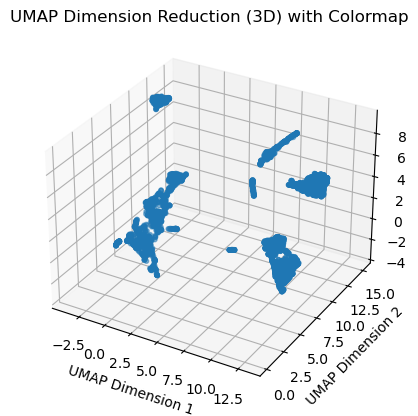

In [71]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Read the CSV file using pandas
csv_file_path = 'Tarcutta-DryA-20210430.csv'  # Update this to your CSV file path
data = pd.read_csv(csv_file_path)
feature_vectors = data.iloc[:, 0:13].values

# Initialize UMAP with desired parameters
reducer = umap.UMAP(n_components=3, random_state=0, n_neighbors=6, min_dist=0)

# Perform dimension reduction
embedding = reducer.fit_transform(feature_vectors)

# Plot the reduced dimensions in a 3D scatterplot with colormap
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], s=10)
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')
ax.set_title('UMAP Dimension Reduction (3D) with Colormap')


plt.show()

Silhouette coefficient testing

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


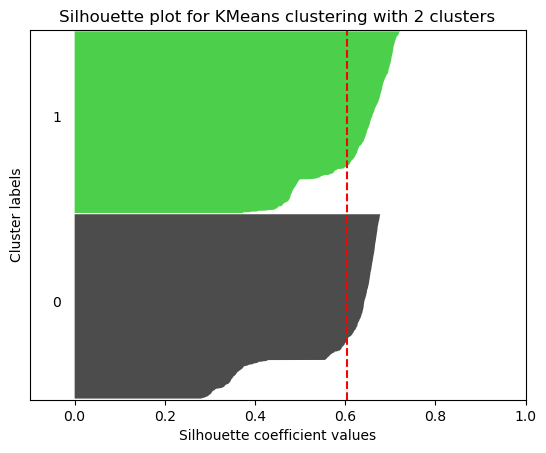

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


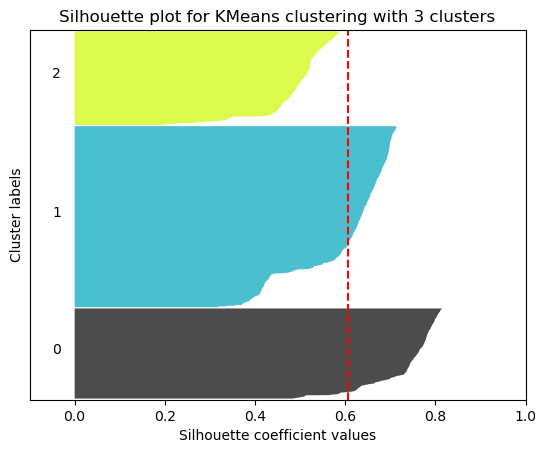

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


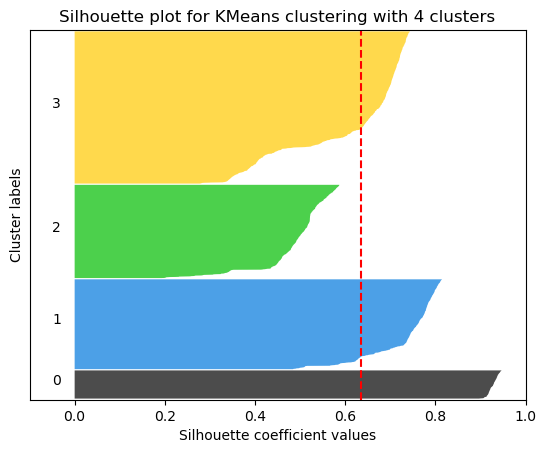

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


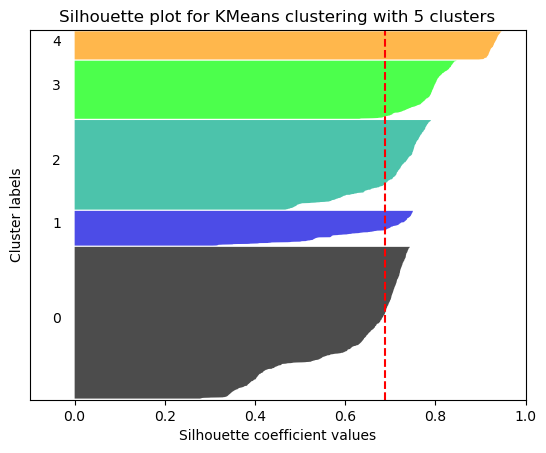

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


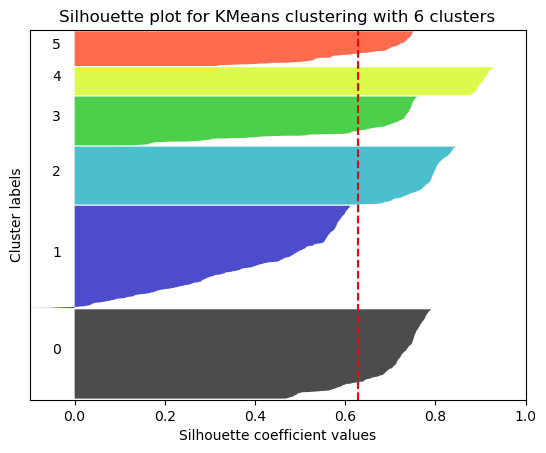

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


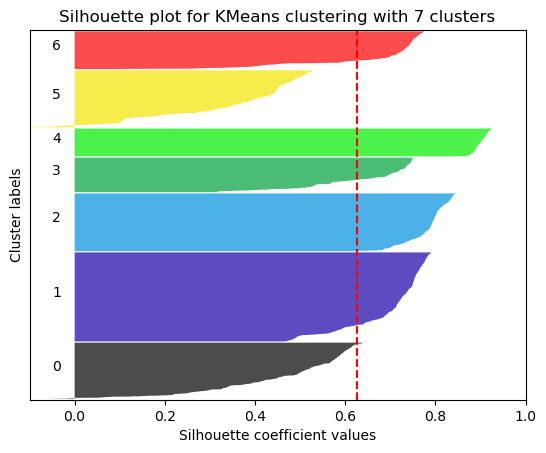

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


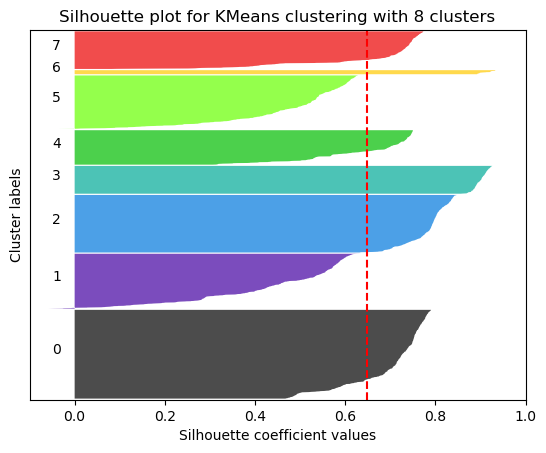

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


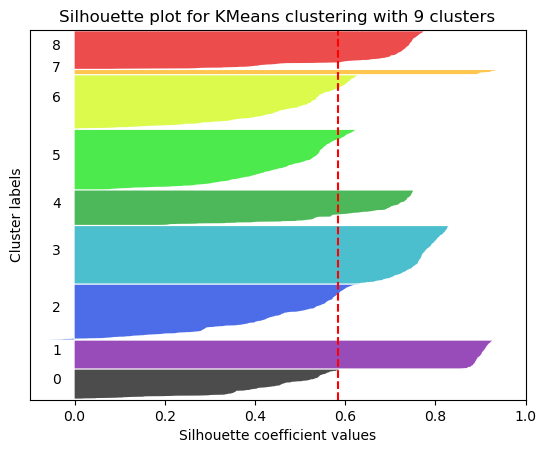

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


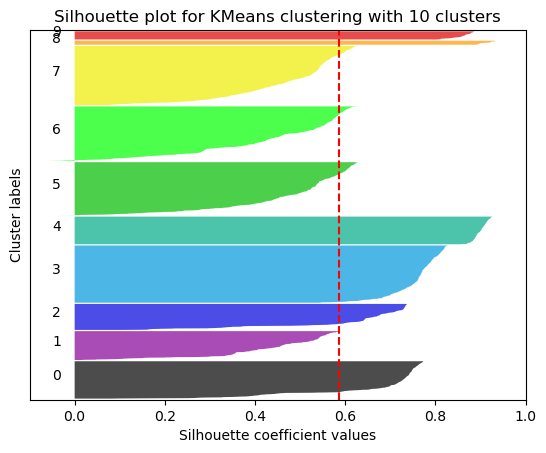

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


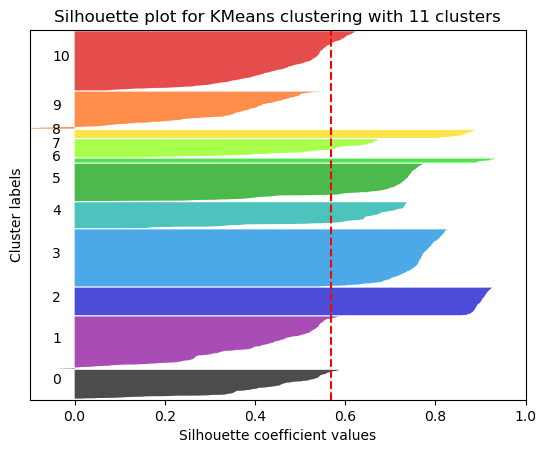

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


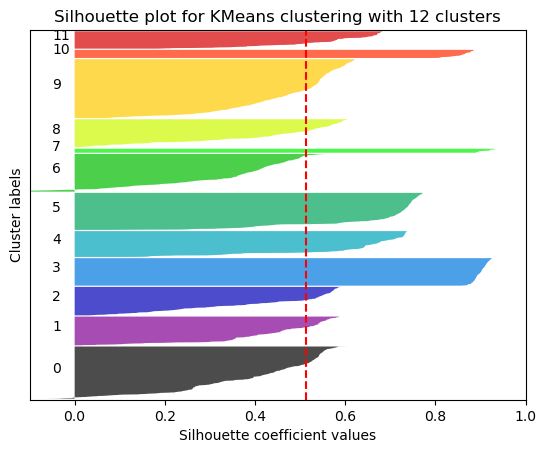

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, silhouette_samples

X = embedding
# Define the range of cluster numbers to evaluate
min_clusters = 2
max_clusters = 12

# Initialize variables to store best cluster number and best silhouette score
best_n_clusters = None
best_score = -1

# Iterate over different cluster numbers and compute silhouette scores and plots
for n_clusters in range(min_clusters, max_clusters+1):
    # Fit KMeans clustering model with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    # Compute silhouette scores and plot
    fig, ax = plt.subplots()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_scores = silhouette_samples(X, kmeans.labels_)
    y_lower = 10
    for i in range(n_clusters):
        cluster_scores = silhouette_scores[kmeans.labels_ == i]
        cluster_scores.sort()
        size_cluster_i = len(cluster_scores)
        y_upper = y_lower + size_cluster_i
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_scores, facecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax.set_title("Silhouette plot for KMeans clustering with {} clusters".format(n_clusters))
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster labels")
    ax.axvline(x=silhouette_score(X, kmeans.labels_, metric='euclidean'), color="red", linestyle="--")
    ax.set_yticks([])
    plt.show()

K-Means

In [73]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5, init='k-means++', random_state=42)
y_km = km.fit_predict(embedding)
labels = km.labels_

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


C:\Users\Thomas\AppData\Local\Temp\ipykernel_21696\2186988326.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')  # Replace with the desired colormap


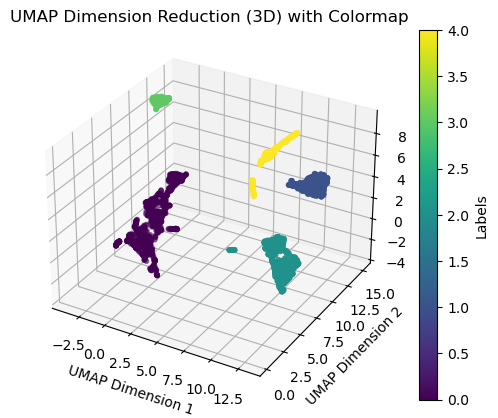

In [74]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have your data stored in a variable called "data"
# Make sure your data is in the shape of (n_samples, n_features)
# Assuming you have a column of labels stored in a variable called "labels"

# Initialize UMAP with desired parameters
reducer = umap.UMAP(n_components=3, random_state=0, n_neighbors=6, min_dist=0)

# Perform dimension reduction
embedding = reducer.fit_transform(feature_vectors)

# Create colormap based on labels
label_colors = labels.astype(int)  # Replace with the actual column of labels
cmap = plt.cm.get_cmap('viridis')  # Replace with the desired colormap

# Plot the reduced dimensions in a 3D scatterplot with colormap
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=label_colors, cmap=cmap, s=10)
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')
ax.set_title('UMAP Dimension Reduction (3D) with Colormap')

# Add a colorbar to the plot
cbar = fig.colorbar(sc)
cbar.set_label('Labels')

plt.show()


Save UMAP data + clustering

In [83]:
import numpy as np

# save the numpy array to a csv file
np.savetxt("umap-Tarcutta-DryA-20210427.csv", embedding, delimiter=",", header="x,y,z")

In [86]:
import csv

# Save labels to a CSV file
filename = "labels.csv"
with open(filename, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Label"])
    for label in labels:
        writer.writerow([label])

Calculate clustering performance measurements (without ground truth available). First by analysing with k-means and then DBScan

In [75]:
import numpy as np
from scipy.spatial.distance import cdist

def optimized_dunn_index(clusters):
    if len(clusters) < 2:
        return 0  # Dunn index is not defined for less than 2 clusters

    # Calculate all pairwise inter-cluster distances and find the minimum
    min_inter_cluster_dist = np.inf
    for i in range(len(clusters) - 1):
        for j in range(i + 1, len(clusters)):
            dist_matrix = cdist(clusters[i], clusters[j], metric='euclidean')
            min_inter_cluster_dist = min(min_inter_cluster_dist, np.min(dist_matrix))

    # Calculate all intra-cluster distances and find the maximum
    max_intra_cluster_dist = 0
    for cluster in clusters:
        if len(cluster) > 1:
            dist_matrix = cdist(cluster, cluster, metric='euclidean')
            max_intra_cluster_dist = max(max_intra_cluster_dist, np.max(dist_matrix))

    return min_inter_cluster_dist / max_intra_cluster_dist if max_intra_cluster_dist != 0 else 0

# Update the function to use the optimized Dunn index calculation
def calculate_dunn_index_optimized(filepath):
    df = pd.read_csv(filepath, usecols=[0, 1, 2, 3], header=None, skiprows=1)
    df.columns = ['x', 'y', 'z', 'class_label']
    clusters = [df[df['class_label'] == label].iloc[:, 0:3].values for label in df['class_label'].unique()]
    return optimized_dunn_index(clusters)

# Recalculate the Dunn indices with the optimized function
dunn_indices_optimized = {filepath.split('/')[-1]: calculate_dunn_index_optimized(filepath) for filepath in filepaths}
dunn_indices_optimized


NameError: name 'filepaths' is not defined

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of

File: umap-Tarcutta-DryA-20210427.csv
Optimal k: 5, Silhouette: 0.6878, Dunn: 0.0000, Davies-Bouldin: 0.3979, Calinski-Harabasz: 8570.8656



C:\Users\Thomas\AppData\Local\Temp\ipykernel_21696\2092618655.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', optimal_k)


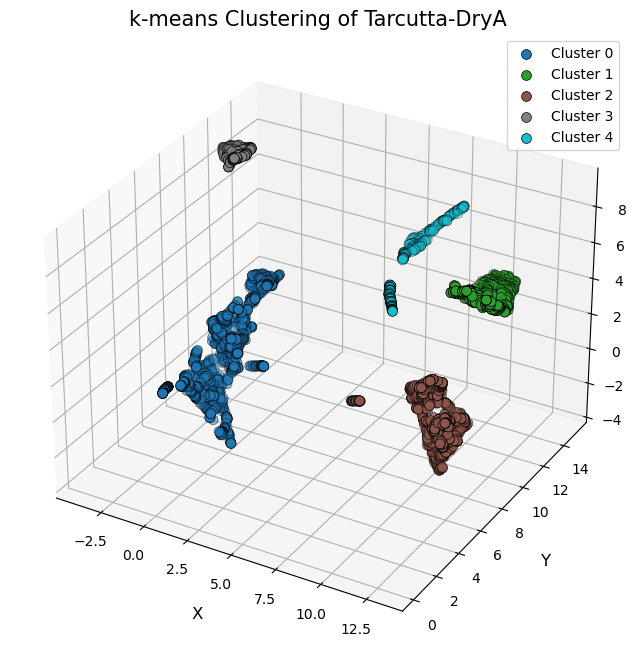

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform
import numpy as np
import os

def dunn_index(X, labels):
    """
    Compute the Dunn index for a clustering.
    X: array-like, shape (n_samples, n_features)
    labels: array-like, shape (n_samples,)
    """
    distances = squareform(pdist(X))
    np.fill_diagonal(distances, np.inf)
    
    intra_cluster_distances = [np.min(distances[labels == label, :][:, labels == label]) for label in np.unique(labels)]
    min_intra_cluster_distance = np.min(intra_cluster_distances)
    
    inter_cluster_distances = []
    unique_labels = np.unique(labels)
    for i, label_i in enumerate(unique_labels[:-1]):
        for label_j in unique_labels[i+1:]:
            inter_cluster_distances.append(np.min(distances[labels == label_i, :][:, labels == label_j]))
    max_inter_cluster_distance = np.max(inter_cluster_distances)
    
    return min_intra_cluster_distance / max_inter_cluster_distance

def visualize_and_cluster(file_path):
    # Load the data
    df = pd.read_csv(file_path)
    
    # Select the first 3 columns for clustering
    data_for_clustering = df.iloc[:, :3].values
    
    # Find the optimal number of clusters
    silhouette_scores = []
    for k in range(2, 11):  # Trying different values of k
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_for_clustering)
        silhouette_scores.append(silhouette_score(data_for_clustering, labels))
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # Adding 2 because range starts at 2
    
    # Apply K-Means clustering with the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    labels = kmeans.fit_predict(data_for_clustering)
    df['cluster'] = labels
    
    # Calculate metrics
    silhouette = silhouette_score(data_for_clustering, labels)
    dunn = dunn_index(data_for_clustering, labels)
    davies_bouldin = davies_bouldin_score(data_for_clustering, labels)
    calinski_harabasz = calinski_harabasz_score(data_for_clustering, labels)
    
    # Print the metrics
    print(f"File: {os.path.basename(file_path)}")
    print(f"Optimal k: {optimal_k}, Silhouette: {silhouette:.4f}, Dunn: {dunn:.4f}, Davies-Bouldin: {davies_bouldin:.4f}, Calinski-Harabasz: {calinski_harabasz:.4f}\n")
    
    # Setup the 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Color map
    colors = plt.cm.get_cmap('tab10', optimal_k)
    
    # Plot each cluster
    for i in range(optimal_k):
        cluster_data = df[df['cluster'] == i]
        ax.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], cluster_data.iloc[:, 2], 
                   color=colors(i), edgecolor='k', s=50, linewidths=0.5, label=f'Cluster {i}')
    
    # Adding grid lines, labels, and legend with clear visibility
    ax.grid(True)
    ax.set_xlabel('X', fontsize=12, labelpad=10)
    ax.set_ylabel('Y', fontsize=12, labelpad=10)
    ax.set_zlabel('Z', fontsize=12, labelpad=15)
    plt.legend()
    plt.title(f"k-means Clustering of Tarcutta-DryA", fontsize=15)
    plt.show()

# Path to the directory containing UMAP files
folder_path = 'C:\\Users\\Thomas\\AudioHandling\\umap-Tarcutta-DryA-20210427.csv'

# Iterate over all UMAP files in the directory
visualize_and_cluster(folder_path)

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform
import numpy as np
import os

def dunn_index(X, labels):
    distances = squareform(pdist(X))
    np.fill_diagonal(distances, np.inf)
    
    intra_cluster_distances = [np.min(distances[labels == label, :][:, labels == label]) for label in np.unique(labels)]
    min_intra_cluster_distance = np.min(intra_cluster_distances)
    
    inter_cluster_distances = []
    unique_labels = np.unique(labels)
    for i, label_i in enumerate(unique_labels[:-1]):
        for label_j in unique_labels[i+1:]:
            inter_cluster_distances.append(np.min(distances[labels == label_i, :][:, labels == label_j]))
    max_inter_cluster_distance = np.max(inter_cluster_distances)
    
    return min_intra_cluster_distance / max_inter_cluster_distance

def normalize_and_calculate_composite_score(silhouette, calinski, davies, dunn, metrics_ranges):
    normalized_silhouette = (silhouette - metrics_ranges['silhouette']['min']) / (metrics_ranges['silhouette']['max'] - metrics_ranges['silhouette']['min'])
    normalized_calinski = (calinski - metrics_ranges['calinski']['min']) / (metrics_ranges['calinski']['max'] - metrics_ranges['calinski']['min'])
    normalized_davies = 1 - ((davies - metrics_ranges['davies']['min']) / (metrics_ranges['davies']['max'] - metrics_ranges['davies']['min']))
    normalized_dunn = (dunn - metrics_ranges['dunn']['min']) / (metrics_ranges['dunn']['max'] - metrics_ranges['dunn']['min'])

    composite_score = normalized_silhouette + normalized_calinski + normalized_davies + normalized_dunn
    return composite_score

def visualize_and_cluster(file_path):
    df = pd.read_csv(file_path)
    data_for_clustering = df.iloc[:, :3].values

    # Initialize metric ranges for normalization
    metrics_ranges = {
        'silhouette': {'min': float('inf'), 'max': float('-inf')},
        'calinski': {'min': float('inf'), 'max': float('-inf')},
        'davies': {'min': float('inf'), 'max': float('-inf')},
        'dunn': {'min': float('inf'), 'max': float('-inf')}
    }

    # Find the optimal number of clusters based on silhouette score
    silhouette_scores = []
    all_metrics = []
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_for_clustering)
        silhouette = silhouette_score(data_for_clustering, labels)
        silhouette_scores.append(silhouette)
        
        # Calculate other metrics for normalization later
        dunn = dunn_index(data_for_clustering, labels)
        davies_bouldin = davies_bouldin_score(data_for_clustering, labels)
        calinski_harabasz = calinski_harabasz_score(data_for_clustering, labels)
        all_metrics.append((silhouette, calinski_harabasz, davies_bouldin, dunn))

        # Update metric ranges
        metrics_ranges['silhouette']['min'] = min(metrics_ranges['silhouette']['min'], silhouette)
        metrics_ranges['silhouette']['max'] = max(metrics_ranges['silhouette']['max'], silhouette)
        metrics_ranges['calinski']['min'] = min(metrics_ranges['calinski']['min'], calinski_harabasz)
        metrics_ranges['calinski']['max'] = max(metrics_ranges['calinski']['max'], calinski_harabasz)
        metrics_ranges['davies']['min'] = min(metrics_ranges['davies']['min'], davies_bouldin)
        metrics_ranges['davies']['max'] = max(metrics_ranges['davies']['max'], davies_bouldin)
        metrics_ranges['dunn']['min'] = min(metrics_ranges['dunn']['min'], dunn)
        metrics_ranges['dunn']['max'] = max(metrics_ranges['dunn']['max'], dunn)

    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2

    # Apply K-Means with the optimal number of clusters and calculate the composite score
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    labels = kmeans.fit_predict(data_for_clustering)
    silhouette, calinski_harabasz, davies_bouldin, dunn = all_metrics[optimal_k - 2]  # -2 because range starts at 2
    composite_score = normalize_and_calculate_composite_score(silhouette, calinski_harabasz, davies_bouldin, dunn, metrics_ranges)

    # Print metrics and composite score
    print(f"File: {os.path.basename(file_path)}")
    print(f"Optimal k: {optimal_k}, Composite Score: {composite_score:.4f}\n")
    print(f"Silhouette: {silhouette:.4f}, Dunn: {dunn:.4f}, Davies-Bouldin: {davies_bouldin:.4f}, Calinski-Harabasz: {calinski_harabasz:.4f}\n")

    # Visualization code remains the same

visualize_and_cluster(folder_path)


c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of

File: umap-Tarcutta-DryA-20210427.csv
Optimal k: 5, Composite Score: nan

Silhouette: 0.6878, Dunn: 0.0000, Davies-Bouldin: 0.3979, Calinski-Harabasz: 8570.8656



c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Thomas\AppData\Local\Temp\ipykernel_21696\3378310099.py:30: RuntimeWarning: invalid value encountered in scalar divide
  normalized_dunn = (dunn - metrics_ranges['dunn']['min']) / (metrics_ranges['dunn']['max'] - metrics_ranges['dunn']['min'])


In [98]:
# Define the datasets with their metrics from the K-Means section of the table
datasets = {
    "Duval-DryA": {"Calinski-Harabasz": 5778.33, "Dunn": 0.0001, "Silhouette": 0.5613, "Davies-Bouldin": 0.6094},
    "Mourachan-WetA": {"Calinski-Harabasz": 6725.93, "Dunn": 0.0000, "Silhouette": 0.7183, "Davies-Bouldin": 0.3958},
    "Rinyirru-WetB": {"Calinski-Harabasz": 8438.32, "Dunn": 0.0000, "Silhouette": 0.6982, "Davies-Bouldin": 0.4024},
    "Tarcutta-DryA": {"Calinski-Harabasz": 8570.8656, "Dunn": 0.0000, "Silhouette": 0.6878, "Davies-Bouldin": 0.3979},
    "Undara-DryB": {"Calinski-Harabasz": 5839.83, "Dunn": 0.0000, "Silhouette": 0.6300, "Davies-Bouldin": 0.4580},
    "Wambiana-WetB": {"Calinski-Harabasz": 14222.55, "Dunn": 0.0000, "Silhouette": 0.7774, "Davies-Bouldin": 0.2667}
}

# Define the ranges for normalization for each metric
ranges = {
    "Calinski-Harabasz": {"min": 5778.33, "max": 14222.55},
    "Dunn": {"min": 0.0000, "max": 0.0001},  # Note: This range might cause issues due to the small max value
    "Silhouette": {"min": 0.5613, "max": 0.7774},
    "Davies-Bouldin": {"min": 0.2667, "max": 0.6094}
}

# Function to normalize, square, and calculate the new composite score
def new_composite_score(metrics, ranges):
    # Normalizing and squaring each metric
    n_silhouette = ((metrics["Silhouette"] - ranges["Silhouette"]["min"]) / (ranges["Silhouette"]["max"] - ranges["Silhouette"]["min"]))**2
    n_calinski = ((metrics["Calinski-Harabasz"] - ranges["Calinski-Harabasz"]["min"]) / (ranges["Calinski-Harabasz"]["max"] - ranges["Calinski-Harabasz"]["min"]))**2
    n_davies = (1 - (metrics["Davies-Bouldin"] - ranges["Davies-Bouldin"]["min"]) / (ranges["Davies-Bouldin"]["max"] - ranges["Davies-Bouldin"]["min"]))**2
    n_dunn = ((metrics["Dunn"] - ranges["Dunn"]["min"]) / (ranges["Dunn"]["max"] - ranges["Dunn"]["min"]))**2
    
    # Summing the squared normalized metrics
    composite = n_silhouette + n_calinski + n_davies + n_dunn
    return composite

# Calculate the new composite score for each dataset
for name, metrics in datasets.items():
    datasets[name]["New Composite Score"] = new_composite_score(metrics, ranges)

datasets


{'Duval-DryA': {'Calinski-Harabasz': 5778.33,
  'Dunn': 0.0001,
  'Silhouette': 0.5613,
  'Davies-Bouldin': 0.6094,
  'New Composite Score': 1.0},
 'Mourachan-WetA': {'Calinski-Harabasz': 6725.93,
  'Dunn': 0.0,
  'Silhouette': 0.7183,
  'Davies-Bouldin': 0.3958,
  'New Composite Score': 0.9289028572528414},
 'Rinyirru-WetB': {'Calinski-Harabasz': 8438.32,
  'Dunn': 0.0,
  'Silhouette': 0.6982,
  'Davies-Bouldin': 0.4024,
  'New Composite Score': 0.8654040199385953},
 'Tarcutta-DryA': {'Calinski-Harabasz': 8570.8656,
  'Dunn': 0.0,
  'Silhouette': 0.6878,
  'Davies-Bouldin': 0.3979,
  'New Composite Score': 0.8329152254486668},
 'Undara-DryB': {'Calinski-Harabasz': 5839.83,
  'Dunn': 0.0,
  'Silhouette': 0.63,
  'Davies-Bouldin': 0.458,
  'New Composite Score': 0.29629348817648216},
 'Wambiana-WetB': {'Calinski-Harabasz': 14222.55,
  'Dunn': 0.0,
  'Silhouette': 0.7774,
  'Davies-Bouldin': 0.2667,
  'New Composite Score': 3.0}}

DBSCAN

In [101]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Function to compute Dunn index
def dunn_index(X, labels):
    distances = squareform(pdist(X))
    np.fill_diagonal(distances, np.inf)
    inter_cluster = np.min(distances[np.where(labels[:, None] != labels[None, :])])
    intra_cluster = max([np.max(pdist(X[labels == i])) for i in np.unique(labels) if i != -1])
    return inter_cluster / intra_cluster if intra_cluster != 0 else 0

# Function to normalize metrics to a 0-1 range, inverting Davies-Bouldin as we aim to minimize it
def normalize_and_calculate_composite_score(silhouette, calinski, davies, dunn, metrics_ranges):
    normalized_silhouette = (silhouette - metrics_ranges['silhouette']['min']) / (metrics_ranges['silhouette']['max'] - metrics_ranges['silhouette']['min'])
    normalized_calinski = (calinski - metrics_ranges['calinski']['min']) / (metrics_ranges['calinski']['max'] - metrics_ranges['calinski']['min'])
    normalized_davies = 1 - ((davies - metrics_ranges['davies']['min']) / (metrics_ranges['davies']['max'] - metrics_ranges['davies']['min']))
    normalized_dunn = (dunn - metrics_ranges['dunn']['min']) / (metrics_ranges['dunn']['max'] - metrics_ranges['dunn']['min'])

    # Composite score calculation
    composite_score = normalized_silhouette + normalized_calinski + normalized_davies + normalized_dunn
    return normalized_silhouette, normalized_calinski, normalized_davies, normalized_dunn, composite_score

# Function to optimize DBSCAN and evaluate using the combined metrics strategy
def optimize_and_evaluate_combined(filenames):
    results = []

    for filename in filenames:
        data = pd.read_csv(filename)
        X = data.iloc[:, :3]  # Only the first three columns
        X_scaled = StandardScaler().fit_transform(X)

        best_score = -1
        best_params = {}
        metrics_ranges = {
            'silhouette': {'min': float('inf'), 'max': float('-inf')},
            'calinski': {'min': float('inf'), 'max': float('-inf')},
            'davies': {'min': float('inf'), 'max': float('-inf')},
            'dunn': {'min': float('inf'), 'max': float('-inf')}
        }

        # First pass: determine the range of each metric
        for eps in np.arange(0.1, 1.5, 0.1):
            for min_samples in range(2, 10):
                db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
                labels = db.labels_
                
                # Skipping evaluation if only one or no cluster found
                if len(set(labels)) <= 1 or (len(set(labels)) == 2 and -1 in labels):
                    continue

                silhouette = silhouette_score(X_scaled, labels)
                calinski = calinski_harabasz_score(X_scaled, labels)
                davies = davies_bouldin_score(X_scaled, labels)
                dunn = dunn_index(X_scaled, labels)

                metrics_ranges['silhouette']['min'] = min(metrics_ranges['silhouette']['min'], silhouette)
                metrics_ranges['silhouette']['max'] = max(metrics_ranges['silhouette']['max'], silhouette)
                metrics_ranges['calinski']['min'] = min(metrics_ranges['calinski']['min'], calinski)
                metrics_ranges['calinski']['max'] = max(metrics_ranges['calinski']['max'], calinski)
                metrics_ranges['davies']['min'] = min(metrics_ranges['davies']['min'], davies)
                metrics_ranges['davies']['max'] = max(metrics_ranges['davies']['max'], davies)
                metrics_ranges['dunn']['min'] = min(metrics_ranges['dunn']['min'], dunn)
                metrics_ranges['dunn']['max'] = max(metrics_ranges['dunn']['max'], dunn)

        # Second pass: calculate the composite score using the ranges determined in the first pass
        for eps in np.arange(0.1, 1.5, 0.1):
            for min_samples in range(2, 10):
                db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
                labels = db.labels_
                
                # Skipping evaluation if only one or no cluster found
                if len(set(labels)) <= 1 or (len(set(labels)) == 2 and -1 in labels):
                    continue

                silhouette = silhouette_score(X_scaled, labels)
                calinski = calinski_harabasz_score(X_scaled, labels)
                davies = davies_bouldin_score(X_scaled, labels)
                dunn = dunn_index(X_scaled, labels)

                normalized_silhouette, normalized_calinski, normalized_davies, normalized_dunn, composite_score = normalize_and_calculate_composite_score(silhouette, calinski, davies, dunn, metrics_ranges)

                if composite_score > best_score:
                    best_score = composite_score
                    best_params = {
                        'eps': eps,
                        'min_samples': min_samples,
                        'Silhouette': silhouette,
                        'Calinski-Harabasz': calinski,
                        'Davies-Bouldin': davies,
                        'Dunn': dunn,
                        'Composite Score': composite_score  # Add the composite score to the best params
                    }

        results.append({filename: best_params})

    return results

# List of dataset filenames
filenames = [
    folder_path
]


# Optimizing DBSCAN and evaluating models
results = optimize_and_evaluate_combined(filenames)
print(results)

[{'C:\\Users\\Thomas\\AudioHandling\\umap-Tarcutta-DryA-20210427.csv': {'eps': 0.9, 'min_samples': 2, 'Silhouette': 0.5860906139904638, 'Calinski-Harabasz': 3248.4871588442647, 'Davies-Bouldin': 0.5160547872938361, 'Dunn': 0.3563063452675368, 'Composite Score': 3.6610680131008135}}]


In [102]:
from sklearn.cluster import DBSCAN

# Create a DBSCAN instance with specified parameters
eps = 0.9  # Neighborhood distance threshold 0.042
min_samples = 2  # Minimum number of samples in a neighborhood 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit the DBSCAN model to the data
dbscan.fit(embedding)

# Get the cluster labels assigned by DBSCAN
labels = dbscan.labels_

# Get the number of clusters (excluding noise points)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Get the indices of the core samples (non-noise points)
core_samples_indices = dbscan.core_sample_indices_

# Print the cluster labels and number of clusters
print("Cluster Labels:", labels)
print("Number of Clusters:", n_clusters)

Cluster Labels: [0 0 0 ... 2 2 2]
Number of Clusters: 8


C:\Users\Thomas\AppData\Local\Temp\ipykernel_21696\2186988326.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')  # Replace with the desired colormap


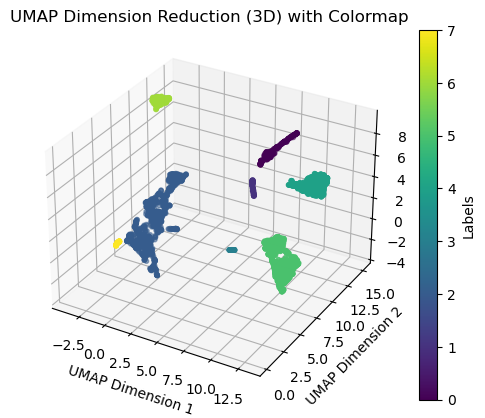

In [103]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have your data stored in a variable called "data"
# Make sure your data is in the shape of (n_samples, n_features)
# Assuming you have a column of labels stored in a variable called "labels"

# Initialize UMAP with desired parameters
reducer = umap.UMAP(n_components=3, random_state=0, n_neighbors=6, min_dist=0)

# Perform dimension reduction
embedding = reducer.fit_transform(feature_vectors)

# Create colormap based on labels
label_colors = labels.astype(int)  # Replace with the actual column of labels
cmap = plt.cm.get_cmap('viridis')  # Replace with the desired colormap

# Plot the reduced dimensions in a 3D scatterplot with colormap
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=label_colors, cmap=cmap, s=10)
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')
ax.set_title('UMAP Dimension Reduction (3D) with Colormap')

# Add a colorbar to the plot
cbar = fig.colorbar(sc)
cbar.set_label('Labels')

plt.show()


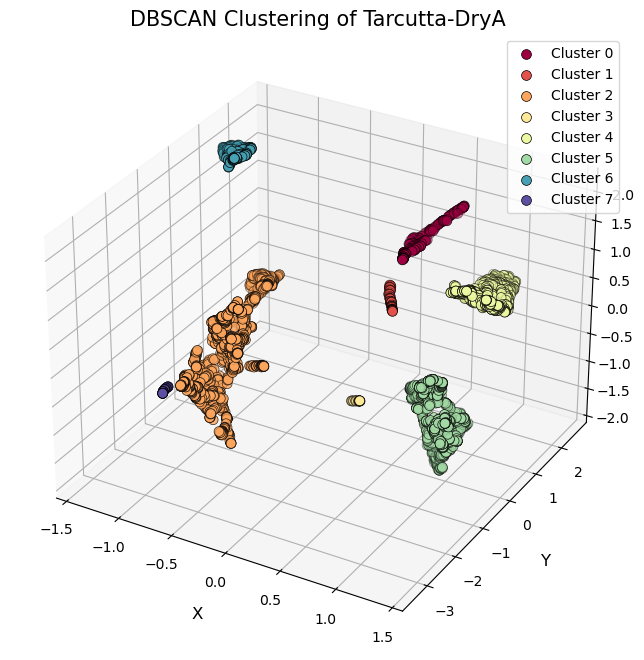

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import os

# Optimized parameters for each dataset
optimized_params = {
    folder_path: {'eps': 0.3, 'min_samples': 2}
}

def visualize_clustered_data(file_path, eps, min_samples):
    # Load the data
    df = pd.read_csv(file_path)

    # Keeping only the required columns
    df = df[['x', 'y', 'z']]

    # Data scaling
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # Clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(scaled_data)
    labels = db.labels_

    # Setup the 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plotting each cluster
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xyz = scaled_data[class_member_mask]
        ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[col], edgecolors='k', s=50, linewidths=0.5, label=f'Cluster {k}')

    # Adding grid lines, labels, and legend with clear visibility
    ax.grid(True)
    ax.set_xlabel('X', fontsize=12, labelpad=10)
    ax.set_ylabel('Y', fontsize=12, labelpad=10)
    ax.set_zlabel('Z', fontsize=12, labelpad=15)

    plt.title(f'DBSCAN Clustering of Tarcutta-DryA', fontsize=15)
    plt.legend()
    plt.show()

# Iterate over each dataset and visualize
for file_name, params in optimized_params.items():
    file_path = os.path.join(folder_path, file_name)
    if os.path.exists(file_path):
        visualize_clustered_data(file_path, **params)
    else:
        print(f"File {file_name} not found in {folder_path}")


Calculate scores with updated composite score

In [108]:
# Define the datasets with their metrics
datasets = {
    "Duval-DryA": {"Calinski-Harabasz": 665.01, "Dunn": 0.322, "Silhouette": 0.397, "Davies-Bouldin": 0.637},
    "Mourachan-WetA": {"Calinski-Harabasz": 6481.30, "Dunn": 0.417, "Silhouette": 0.733, "Davies-Bouldin": 0.359},
    "Rinyirru-WetB": {"Calinski-Harabasz": 4620.01, "Dunn": 0.377, "Silhouette": 0.654, "Davies-Bouldin": 0.324},
    "Tarcutta-DryA": {"Calinski-Harabasz": 3248.48, "Dunn": 0.356, "Silhouette": 0.586, "Davies-Bouldin": 0.516},
    "Undara-DryB": {"Calinski-Harabasz": 1564.99, "Dunn": 0.084, "Silhouette": 0.475, "Davies-Bouldin": 0.453},
    "Wambiana-WetB": {"Calinski-Harabasz": 10160.87, "Dunn": 0.628, "Silhouette": 0.745, "Davies-Bouldin": 0.302}
}

# Define the ranges for normalization for each metric
ranges = {
    "Calinski-Harabasz": {"min": min(d["Calinski-Harabasz"] for d in datasets.values()), "max": max(d["Calinski-Harabasz"] for d in datasets.values())},
    "Dunn": {"min": min(d["Dunn"] for d in datasets.values()), "max": max(d["Dunn"] for d in datasets.values())},
    "Silhouette": {"min": min(d["Silhouette"] for d in datasets.values()), "max": max(d["Silhouette"] for d in datasets.values())},
    "Davies-Bouldin": {"min": min(d["Davies-Bouldin"] for d in datasets.values()), "max": max(d["Davies-Bouldin"] for d in datasets.values())}
}

# Function to normalize, square, and calculate the new composite score
def new_composite_score(metrics, ranges):
    # Normalizing and squaring each metric
    n_silhouette = ((metrics["Silhouette"] - ranges["Silhouette"]["min"]) / (ranges["Silhouette"]["max"] - ranges["Silhouette"]["min"]))**2
    n_calinski = ((metrics["Calinski-Harabasz"] - ranges["Calinski-Harabasz"]["min"]) / (ranges["Calinski-Harabasz"]["max"] - ranges["Calinski-Harabasz"]["min"]))**2
    n_davies = (1 - (metrics["Davies-Bouldin"] - ranges["Davies-Bouldin"]["min"]) / (ranges["Davies-Bouldin"]["max"] - ranges["Davies-Bouldin"]["min"]))**2
    n_dunn = ((metrics["Dunn"] - ranges["Dunn"]["min"]) / (ranges["Dunn"]["max"] - ranges["Dunn"]["min"]))**2
    
    # Summing the squared normalized metrics
    composite = n_silhouette + n_calinski + n_davies + n_dunn
    return composite

# Calculate the new composite score for each dataset
for name, metrics in datasets.items():
    datasets[name]["New Composite Score"] = new_composite_score(metrics, ranges)

datasets


{'Duval-DryA': {'Calinski-Harabasz': 665.01,
  'Dunn': 0.322,
  'Silhouette': 0.397,
  'Davies-Bouldin': 0.637,
  'New Composite Score': 0.19140624999999994},
 'Mourachan-WetA': {'Calinski-Harabasz': 6481.3,
  'Dunn': 0.417,
  'Silhouette': 0.733,
  'Davies-Bouldin': 0.359,
  'New Composite Score': 2.370747844085998},
 'Rinyirru-WetB': {'Calinski-Harabasz': 4620.01,
  'Dunn': 0.377,
  'Silhouette': 0.654,
  'Davies-Bouldin': 0.324,
  'New Composite Score': 1.881923344154023},
 'Tarcutta-DryA': {'Calinski-Harabasz': 3248.48,
  'Dunn': 0.356,
  'Silhouette': 0.586,
  'Davies-Bouldin': 0.516,
  'New Composite Score': 0.7494406349739848},
 'Undara-DryB': {'Calinski-Harabasz': 1564.99,
  'Dunn': 0.084,
  'Silhouette': 0.475,
  'Davies-Bouldin': 0.453,
  'New Composite Score': 0.36089997113740857},
 'Wambiana-WetB': {'Calinski-Harabasz': 10160.87,
  'Dunn': 0.628,
  'Silhouette': 0.745,
  'Davies-Bouldin': 0.302,
  'New Composite Score': 4.0}}